In [1]:
import time
import json
import urllib.request
import sqlite3
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

conn =sqlite3.connect('parking20171024-16h.sqlite')
cursor = conn.cursor()

class Parking:
    
    def __init__(self,number):
        self.__state = []
        self.__time = []
        self.__capacity = 0
        self.__name = number
        
        cursor.execute("SELECT * from {}".format(number))
        data = cursor.fetchall()
        i = 0
        for row in data:
            dateString = row[1]
            if i == 0:
                self.__capacity= int(row[3])
            try:
                if i>=0:
                    self.__time.append(datetime.strptime(dateString,'%Y-%m-%d %H:%M:%S'))
                    state = row[2].split(' ')[0]
                    if not (state.isdigit()):
                        state = 0
                    state = int(state)
                    self.__state.append(state)
            except  ValueError:
                continue
            if i>100000:
                return
            i+=1
        return
            
    def getTimeTable(self):
        return self.__time
    
    def getStateTable(self):
        return self.__state
    
    def getCapacity(self):
        return self.__capacity
    
    def binaryTimeSearch(self,dateTime,start,end):
        middle = (start+end)//2 
        if start == end:
            return start
        if self.__time[middle] == dateTime:
            return middle
        if self.__time[middle]>dateTime:
            end = middle
            return self.binaryTimeSearch(dateTime,start,end)
        if self.__time[middle]<dateTime:
            start = middle+1
            return self.binaryTimeSearch(dateTime,start,end)
        if start == end and self.__time[middle]//2:
            return middle
        
        
        
    def plot(self,date1,date2):
        dateTime1 = datetime.strptime(date1,'%Y/%d/%m')
        dateTime2 = datetime.strptime(date2,'%Y/%d/%m')
        ind1 = self.binaryTimeSearch(dateTime1,0,len(self.__time))
        ind2 = self.binaryTimeSearch(dateTime2,0,len(self.__time))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 1))
        plt.plot(self.__time[ind1:(ind2+1)],self.__state[ind1:(ind2+1)])
        plt.gcf().autofmt_xdate()
        
    def plotAll(self):
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 7))
        plt.plot(self.__time,self.__state)
        plt.gcf().autofmt_xdate()
    
    def classifyByVar(self):
        print("Classifying by variance")
        dayValues =  []
        dayVar = []
        days = [ ]
        dayTemp = self.__time[0].date()
        for i in range(len(self.__time)):
            moment = self.__time[i]
            if moment.date() == dayTemp:
                dayValues.append(self.__state[i])
            else:
                m = sum(dayValues) / len(dayValues)
                dayVar.append(sum([(xi - m)**2 for xi in dayValues]) / len(dayValues))
                days.append(dayTemp)
                dayValues = [self.__state[i]]
                dayTemp = moment.date()
        return (dayVar,days)
    
    def getArrivingCarsHour(self):
        result = []
        dateList = []
        momentBefore = self.__time[0]
        availabilityBefore = self.__state[3]
        n = 0
        for i in range(4,len(self.__time)):
            moment  = self.__time[i]
            availability = self.__state[i]
            if moment.hour == momentBefore.hour and moment.hour>4 and moment<datetime(2017,10,1,0,0,0):
                if availability<availabilityBefore:
                    delta = availabilityBefore - availability
                    deltaTime = (moment - momentBefore).total_seconds()
                    n += delta/deltaTime
            elif moment.hour != momentBefore.hour and moment.hour>4 and moment<datetime(2017,10,1,0,0,0):
                dateList.append(datetime(momentBefore.year,momentBefore.month,momentBefore.day,momentBefore.hour,0,0))
                result.append(n)
                momentBefore = moment
                availabilityBefore = availability
                n = 0
        return (dateList,result)
    
    
    def organizeDataByDayMin(self):
        minList = []
        dateList = []
        tempValues = []
        minTemp = 2000
        momentBefore = self.__time[0]
        i = 0
        for i in range(len(self.__time)):
            moment  = self.__time[i] + timedelta(minutes = 30)
            state = self.__state[i]
            if moment.hour == momentBefore.hour and minTemp > state and moment.hour>4:
                tempValues.append(state)
                minTemp = state
            else:
                dateList.append(datetime(momentBefore.year,momentBefore.month,momentBefore.day,0,0,0))
                minList.append(minTemp)
                momentBefore = moment
                minTemp = 2000
        return (dateList,minList)
    
    def organizeDataByDayMax(self):
        maxList = []
        dateList = []
        tempValues = []
        maxTemp = -20000
        momentBefore = self.__time[0]
        for i in range(4,len(self.__time)):
            moment  = self.__time[i] + timedelta(minutes = 30)
            state = - self.__state[i] + self.__capacity
            if moment.hour == momentBefore.hour and maxTemp < state and moment.hour>4 and moment<datetime(2017,10,1,0,0,0):
                tempValues.append(state)
                maxTemp = state
            elif moment.hour != momentBefore.hour and moment.hour>4 and moment<datetime(2017,10,1,0,0,0):
                dateList.append(datetime(momentBefore.year,momentBefore.month,momentBefore.day,momentBefore.hour,0,0))
                if maxTemp == -20000:
                    if len(maxList)>0:
                        maxList.append(maxList[-1])
                    else:
                        maxList.append(1)
                else:
                    maxList.append(maxTemp)
                momentBefore = moment
                maxTemp = -20000
        return (dateList,maxList)
    
    #round to nearest hour (e.g. 10:40 -> 11:00)
    def organizeDataByHour(self):
        MeanStateByHourList = []
        hourList = []
        tempValues = []
        momentBefore = self.__time[0]
        i = 0
        for i in range(len(self.__time)):
            moment  = self.__time[i] + timedelta(minutes = 30)
            state = self.__state[i]
            if moment.hour == momentBefore.hour:
                tempValues.append(state)
            else:
                updatedMoment = (datetime(momentBefore.year, momentBefore.month,momentBefore.day, momentBefore.hour, 0,0))
                hourList.append(updatedMoment)
                MeanStateByHourList.append(sum(tempValues)/len(tempValues))
                momentBefore = moment
        return (hourList,MeanStateByHourList)
    
    
    def getDailyMinHour(self):
        print("Classifying by variance")
        dayValues =  []
        seuil = 5
        days = [ ]
        dayVar = []
        dayMin = []
        dayMean = []
        weekdays = []
        minHours = []
        minHour = None
        minTemp = 2000
        dayTemp = self.__time[0].date()
        for i in range(len(self.__time)):
            moment = self.__time[i].add
            state = self.__state[i]
            #print(moment, self.__state[i])
            if moment.date() == dayTemp:
                if len(dayValues)>200 and minTemp-20>state:
                    minTemp = state
                    minHour = moment.hour + moment.minute/60
                    #print(moment,self.__state[i],'#########################################')
                dayValues.append(self.__state[i])
                
            else:
                if minHour!= None:
                    min_val = min(dayValues)
                    m = sum(dayValues) / len(dayValues)/self.__capacity
                    var = (sum([(xi - m)**2 for xi in dayValues]) / len(dayValues))
                    if var>seuil and len(dayValues)>100:
                        dayMean.append(m)
                        minHours.append(minHour)
                        weekdays.append(moment.weekday())
                        dayVar.append(var)
                        dayMin.append(min_val)
                        days.append(dayTemp)
                dayValues = [self.__state[i]]
                dayTemp = moment.date()
                minTemp = 2000
        return (dayMean,minHours)
    def plotMinDay(self,dayMin,days):
        
        #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
        #plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 1))
        plt.scatter(days,dayMin, s = 1)
        plt.savefig('minHourvsState.png', dpi = 300)
#        plt.gcf().autofmt_xdate()
        plt.show()
    
    def classifyByMean(self):
        print("Classifying by variance")
        dayValues =  []
        dayMean = []
        days = [ ]
        dayTemp = self.__time[0].date()
        for i in range(len(self.__time)):
            moment = self.__time[i]
            if moment.date() == dayTemp:
                dayValues.append(self.__state[i])
            else:
                m = sum(dayValues) / len(dayValues)
                dayMean.append(m)
                days.append(dayTemp)
                dayValues = [self.__state[i]]
                dayTemp = moment.date()
        return (dayMean,days)        

['un', 'deux', 'trois', 4, 5, 6, 7, 7, 8, 10, 11, 12, 13, 14, 16, 18, 19, 20, 21, 21, 22, 23, 23, 25, 27, 28, 39, 40, 41, 43, 44, 45, 47, 48, 49, 50, 52, 53, 54, 55, 73, 77, 78, 79, 79, 87, 104, 105, 107, 108]

#parking107 = Parking('centsept')
parking3 = Parking('trois') 

In [2]:
import pandas as pd

#Create a pandas table relating each state to one specific hour
#(timeTable107,stateTable107) = parking107.organizeDataByDayMax()
(timeTable3,stateTable3) = parking3.getArrivingCarsHour()

#stateTable107 = [stateTable107[i]/parking107.getCapacity() for i in range(len(stateTable108))]
stateTable3 = [stateTable3[i] for i in range(len(stateTable3))]

#df = pd.DataFrame({'Hour':timeTable108, 'StateSuburb':stateTable108, 'StateCenter':stateTable10})
#df = pd.DataFrame({'Hour':timeTable107, 'StateSuburb':stateTable107})
df = pd.DataFrame({'Hour':timeTable3, 'StateSuburb':stateTable3})
df.set_index('Hour', inplace = True)
df

,StateSuburb
Hour,
2017-04-19 21:00:00,0.010650
2017-04-19 22:00:00,0.004082
2017-04-19 23:00:00,0.000000
2017-04-20 05:00:00,0.142842
2017-04-20 06:00:00,0.245261
2017-04-20 07:00:00,0.077468
2017-04-20 08:00:00,0.337061
2017-04-20 09:00:00,0.322970
2017-04-20 10:00:00,0.046537


In [3]:
pivoted = df.pivot_table(['StateSuburb'], index = df.index.date, columns = df.index.hour, fill_value =  0)

pivoted

StateSuburb                                                    \
                    5         6         7         8         9         10   
2017-04-19    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2017-04-20    0.142842  0.245261  0.077468  0.337061  0.322970  0.046537   
2017-04-21    0.197891  0.472130  0.200178  0.236498  0.009370  0.005176   
2017-04-22    0.044377  0.100757  0.083401  0.004621  0.104940  0.100856   
2017-04-23    0.059733  0.153074  0.181586  0.000000  0.079830  0.000380   
2017-04-24    0.304556  0.442211  0.747328  0.379945  2.345538  0.033703   
2017-04-25    0.187549  1.165510  0.176120  0.073213  0.140399  0.003578   
2017-04-26    0.152630  0.786237  0.112260  0.113465  0.000000  0.031744   
2017-04-27    0.156529  0.944138  0.030706  0.215025  0.000000  0.523539   
2017-04-28    0.000000  0.000000  0.155334  7.323846  2.030898  0.000000   
2017-04-29    0.000000  0.080589  0.791485  0.050850  0.102127  0.123116   
2017-04-30    0.000000  2.365676  1.118987  0.003474  1.864607  2.789240   
2017-05-01    0.881951  0.103531  2.652635  1.207157  0.000000  0.000000   
2017-05-02    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2017-05-03    0.274634  2.037459  1.674854  0.447356  0.519347  0.029619   
2017-05-04    0.182074  1.432244  0.219614  0.031968  0.020952  0.192865   
2017-05-05    0.000000  0.785745  0.489532  0.536823  0.194062  0.133830   
2017-05-06    0.000000  0.000000  2.457497  0.000000  0.000000  0.222828   
2017-05-07    2.896534  0.000000  2.849427  0.000000  1.325937  0.078738   
2017-05-08    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2017-05-09    0.000000  0.000000  0.000000  0.000000  5.025632  0.000000   
2017-05-10    0.000000  0.000000  0.831737  0.049780  0.112102  0.000000   
2017-05-11    0.000000  0.000000  4.252538  0.000000  0.388189  0.062221   
2017-05-12    0.187781  0.559778  0.165695  0.078051  0.240674  0.078487   
2017-05-13    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2017-05-14    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2017-05-15    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2017-05-16    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2017-05-17    0.110689  1.225071  0.793514  0.393328  0.518437  0.000000   
2017-05-18    0.026991  1.115477  0.070950  0.193118  0.171986  0.161933   
...                ...       ...       ...       ...       ...       ...   
2017-08-05    0.034242  0.026230  0.002918  0.023679  0.075784  0.001968   
2017-08-06    0.095189  0.025338  0.049022  0.000000  0.006806  0.057316   
2017-08-07    0.135328  0.050312  0.114471  0.070426  0.042114  0.028822   
2017-08-08    0.131311  0.000000  0.011041  0.061024  0.094870  0.024990   
2017-08-09    0.112404  0.091490  0.026952  0.006969  0.048220  0.043371   
2017-08-10    0.011413  0.024471  0.066249  0.011389  0.008009  0.037863   
2017-08-11    0.084795  0.002741  0.018058  0.046217  0.017999  0.000000   
2017-08-12    0.057681  0.098001  0.003365  0.004666  0.009670  0.016245   
2017-08-13    0.068610  0.031204  0.046369  0.014158  0.002390  0.016947   
2017-08-14    0.065037  0.007385  0.017553  0.011434  0.024527  0.028329   
2017-08-15    0.055285  0.068014  0.037407  0.028847  0.000814  0.010715   
2017-08-16    0.067456  0.167247  0.035619  0.005937  0.032767  0.057778   
2017-08-17    0.131144  7.904907  0.000000  0.000000  0.000000  0.000000   
2017-08-18    0.069754  0.042460  0.007481  0.020851  0.076125  0.076757   
2017-08-19    0.067614  0.002833  0.039599  0.012302  0.132677  0.012570   
2017-08-20    0.055200  0.030596  0.059335  0.001284  0.080790  0.019058   
2017-08-21    0.167956  0.133220  0.069388  0.120392  0.008535  0.011054   
2017-08-22    0.171553  0.242070  0.036440  0.050680  0.115072  0.013407   
2017-08-23    0.000000  0.000000  0.000000  0.000000  0.075022  0.097651   
2017-08-24    0.148106  0.044180  0.125294  0.074639  0.048

In [4]:
X = pivoted.values
X.shape

(138, 19)

In [5]:
from sklearn.decomposition import PCA
Xpca = PCA(0.8).fit_transform(X)
Xpca.shape

(138, 6)

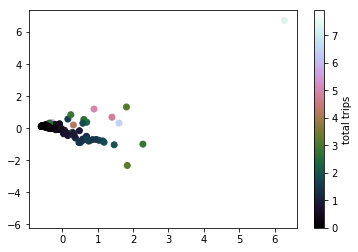

In [6]:
total_trips = X.max(1)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=total_trips,
            cmap='cubehelix')
plt.colorbar(label='total trips');
plt.show()

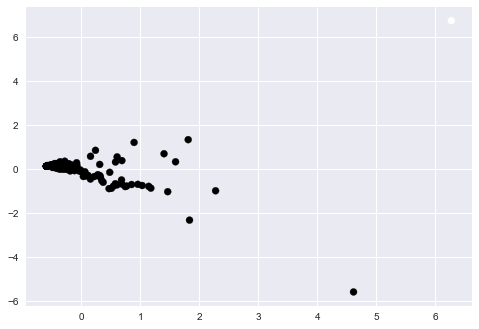

In [7]:
import warnings



from sklearn import cluster, datasets, mixture
import seaborn; seaborn.set()

nbClusters =  2
gmm = mixture.GaussianMixture(n_components=nbClusters, covariance_type='full')

with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            gmm.fit(X)
            clusterPrediction = gmm.predict(X)

plt.scatter(Xpca[:, 0], Xpca[:, 1], c=clusterPrediction,cmap='cubehelix')
plt.show() 


In [8]:
pivoted['Cluster'] = clusterPrediction
df = df.join(pivoted['Cluster'], on=df.index.date, lsuffix ='_left', rsuffix = '_right')
df
df0 = df.loc[df['Cluster'] == 0]
df1 = df.loc[df['Cluster'] == 1]

In [9]:
by_hour = df.groupby(['Cluster', df.index.date]).mean()
by_hour

StateSuburb
Cluster                        
0       2017-04-19     0.004911
        2017-04-20     0.092864
        2017-04-21     0.096353
        2017-04-22     0.061161
        2017-04-23     0.090269
        2017-04-24     0.238045
        2017-04-25     0.120772
        2017-04-26     0.134878
        2017-04-27     0.353855
        2017-04-29     0.204977
        2017-04-30     0.698485
        2017-05-01     0.255014
        2017-05-02     0.041956
        2017-05-03     0.284603
        2017-05-04     0.196085
        2017-05-05     0.576009
        2017-05-06     0.209093
        2017-05-07     0.717531
        2017-05-08     0.152049
        2017-05-09     0.424160
        2017-05-10     0.387710
        2017-05-11     0.260374
        2017-05-12     0.098773
        2017-05-13     0.000000
        2017-05-14     0.000000
        2017-05-15     0.000000
        2017-05-16     0.015857
        2017-05-17     0.166530
        2017-05-18     0.105009
        2017-05-19     0.143932
...                         ...
        2017-08-06     0.035661
        2017-08-07     0.038846
        2017-08-08     0.035259
        2017-08-09     0.035493
        2017-08-10     0.024480
        2017-08-11     0.082970
        2017-08-12     0.035480
        2017-08-13     0.021223
        2017-08-14     0.026588
        2017-08-15     0.034026
        2017-08-16     0.032247
        2017-08-17     0.436202
        2017-08-18     0.027200
        2017-08-19     0.032395
        2017-08-20     0.035190
        2017-08-21     0.048327
        2017-08-22     0.043871
        2017-08-23     0.028681
        2017-08-24     0.034914
        2017-08-25     0.041250
        2017-08-26     0.031159
        2017-08-27     0.025701
        2017-08-28     0.095018
        2017-08-29     0.162048
        2017-09-01     0.080932
        2017-09-04     0.136240
        2017-09-14     0.000000
        2017-09-15     0.000000
        2017-09-17     0.000000
1       2017-04-28     1.278640

[138 rows x 1 columns]

In [10]:
df_def = df0

In [13]:
pivoted_1 = df_def.pivot_table(['StateSuburb'], index = df_def.index.date, columns = df_def.index.hour, fill_value =  0)

pivoted_1.head()

X = pivoted_1.values
X.shape

(137, 19)

In [14]:
from sklearn.decomposition import PCA
Xpca0 = PCA(0.8).fit_transform(X)
Xpca0.shape

(137, 6)

In [15]:

Xpca = PCA(0.5).fit_transform(Xpca0)
Xpca.shape

(137, 2)

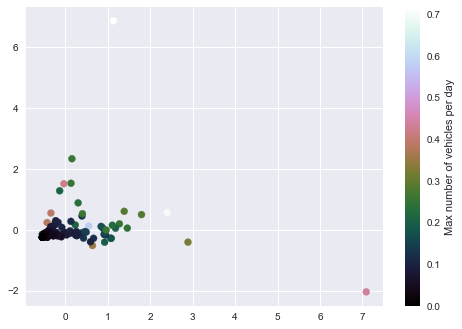

In [18]:
total_trips = X.mean(1)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=total_trips,
            cmap='cubehelix')
plt.colorbar(label='Max number of vehicles per day');
plt.show()

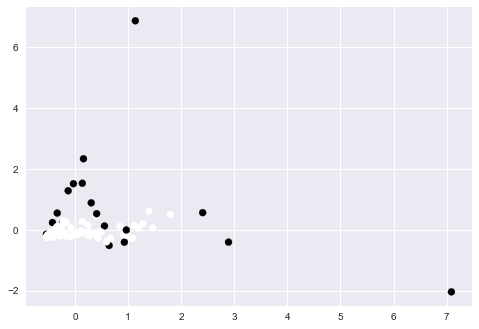

In [23]:
import warnings
import numpy as np


from sklearn import cluster, datasets, mixture
import seaborn; seaborn.set()

ap = cluster.AffinityPropagation(damping = 0.9, preference = 0)

dbscan = cluster.DBSCAN(eps=1.5, min_samples = 5)

db = dbscan.fit(X)

clusterPrediction = dbscan.labels_.astype(np.int)

plt.scatter(Xpca[:, 0], Xpca[:, 1], c=clusterPrediction,cmap='cubehelix')
plt.show() 

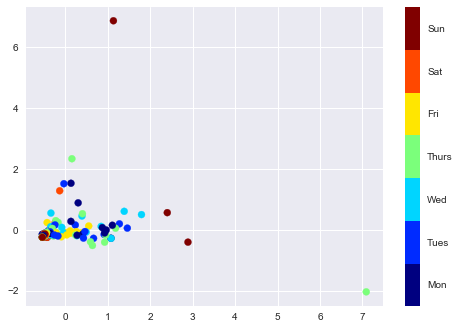

In [24]:
dayofweek = pd.to_datetime(pivoted_1.index).dayofweek

plt.scatter(Xpca[:, 0], Xpca[:, 1], c=dayofweek,cmap=plt.cm.get_cmap('jet', 7)) 
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.clim(-0.5, 6.5);
plt.show()

In [ ]:
X = pivoted_1.values
X.shape

In [29]:
results = pd.DataFrame({'cluster': clusterPrediction,
                        'is_weekend': (dayofweek > 4),
                        'weekday': pivoted_1.index.map(lambda x: x.strftime('%a'))},
                       index=pivoted_1.index)

groupedResults = results.groupby(['cluster', results.index]).mean()
groupedResults

is_weekend
cluster                      
-1      2017-04-24      False
        2017-04-27      False
        2017-04-29       True
        2017-04-30       True
        2017-05-01      False
        2017-05-04      False
        2017-05-05      False
        2017-05-06       True
        2017-05-07       True
        2017-05-08      False
        2017-05-09      False
        2017-05-10      False
        2017-05-11      False
        2017-05-26      False
        2017-06-08      False
        2017-06-11       True
        2017-07-10      False
        2017-07-15       True
        2017-08-17      False
 0      2017-04-19      False
        2017-04-20      False
        2017-04-21      False
        2017-04-22       True
        2017-04-23       True
        2017-04-25      False
        2017-04-26      False
        2017-05-02      False
        2017-05-03      False
        2017-05-12      False
        2017-05-13       True
...                       ...
        2017-08-04      False
        2017-08-05       True
        2017-08-06       True
        2017-08-07      False
        2017-08-08      False
        2017-08-09      False
        2017-08-10      False
        2017-08-11      False
        2017-08-12       True
        2017-08-13       True
        2017-08-14      False
        2017-08-15      False
        2017-08-16      False
        2017-08-18      False
        2017-08-19       True
        2017-08-20       True
        2017-08-21      False
        2017-08-22      False
        2017-08-23      False
        2017-08-24      False
        2017-08-25      False
        2017-08-26       True
        2017-08-27       True
        2017-08-28      False
        2017-08-29      False
        2017-09-01      False
        2017-09-04      False
        2017-09-14      False
        2017-09-15      False
        2017-09-17       True

[137 rows x 1 columns]